In [1]:
# 11_hybrid_model.ipynb  — Hybrid recommender (Cosine + ALS + Item2Vec + Cluster bonus)

import os
from pathlib import Path

import numpy as np
import pandas as pd

from tqdm.auto import tqdm

# Plotting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# ML utils
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

# ALS (implicit feedback)
import implicit

# Item2Vec
from gensim.models import KeyedVectors

PROJECT_ROOT = Path("..").resolve()
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
MODELS_DIR = PROJECT_ROOT / "models"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_PROCESSED:", DATA_PROCESSED)
print("MODELS_DIR:", MODELS_DIR)


c:\Users\Kiera\Music_Recommender\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PROJECT_ROOT: C:\Users\Kiera\Music_Recommender
DATA_PROCESSED: C:\Users\Kiera\Music_Recommender\data\processed
MODELS_DIR: C:\Users\Kiera\Music_Recommender\models


In [2]:
# Paths
FEATURES_PATH = DATA_PROCESSED / "combined_features.csv"
INTERACTIONS_PATH = DATA_PROCESSED / "interactions.parquet"
TRACK_META_PATH = DATA_PROCESSED / "track_metadata.csv"

# --- Load combined features ---
feat_df = pd.read_csv(FEATURES_PATH)
print("Features shape:", feat_df.shape)

# --- Load track metadata (for names) ---
meta_df = pd.read_csv(TRACK_META_PATH)
print("Track metadata shape:", meta_df.shape)

# --- Load interactions (pid, track_id, pos, duration_ms) ---
inter_df = pd.read_parquet(INTERACTIONS_PATH)
print("Interactions shape:", inter_df.shape)

# Ensure track_id is string everywhere
feat_df["track_id"] = feat_df["track_id"].astype(str)
meta_df["track_id"] = meta_df["track_id"].astype(str)
inter_df["track_id"] = inter_df["track_id"].astype(str)

# Keep only tracks that exist in all 3 (features + metadata + interactions)
track_ids_all = (
    set(feat_df["track_id"])
    & set(meta_df["track_id"])
    & set(inter_df["track_id"])
)

print("Tracks present in ALL (features+meta+interactions):", len(track_ids_all))

feat_df = feat_df[feat_df["track_id"].isin(track_ids_all)].reset_index(drop=True)
meta_df = meta_df[meta_df["track_id"].isin(track_ids_all)].reset_index(drop=True)
inter_df = inter_df[inter_df["track_id"].isin(track_ids_all)].reset_index(drop=True)

print("Filtered shapes:")
print("  features:", feat_df.shape)
print("  meta    :", meta_df.shape)
print("  inter   :", inter_df.shape)

# Simple metadata index for lookups
meta_simple = (
    meta_df[["track_id", "track_name", "artist_name", "album_name"]]
    .drop_duplicates()
    .set_index("track_id")
)


Features shape: (4589288, 17)
Track metadata shape: (679889, 7)
Interactions shape: (6685101, 4)
Tracks present in ALL (features+meta+interactions): 514672
Filtered shapes:
  features: (514672, 17)
  meta    : (514672, 7)
  inter   : (6175813, 4)


In [3]:
# Choose numeric feature columns (everything except ids / non-numerics)
non_feature_cols = {"track_id", "explicit"}  # explicit is often object / messy
feature_cols = [
    c for c in feat_df.columns
    if c not in non_feature_cols and np.issubdtype(feat_df[c].dtype, np.number)
]

print("Feature columns used ({}):".format(len(feature_cols)))
print(feature_cols)

# Impute NaNs with column means
feat_mat = feat_df[feature_cols].copy()
feat_mat = feat_mat.fillna(feat_mat.mean())

# Standardise then L2-normalise rows
scaler = StandardScaler()
X_scaled = scaler.fit_transform(feat_mat.values)

row_norms = np.linalg.norm(X_scaled, axis=1, keepdims=True)
row_norms[row_norms == 0.0] = 1.0
X_norm = X_scaled / row_norms

print("X_norm shape:", X_norm.shape)
print("Mean row norm:", float(np.linalg.norm(X_norm, axis=1).mean()))

# Track index mapping for feature space
track_ids_features = feat_df["track_id"].values
tid_to_feat_idx = {tid: i for i, tid in enumerate(track_ids_features)}

# Cosine KNN index (exact NN with brute-force cosine)
knn_cosine = NearestNeighbors(
    metric="cosine",
    algorithm="brute",
)
knn_cosine.fit(X_norm)

print("Built cosine KNN index.")


Feature columns used (15):
['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'year', 'time_signature', 'popularity']
X_norm shape: (514672, 15)
Mean row norm: 1.0
Built cosine KNN index.


In [4]:
from gensim.models import Word2Vec

# Directory for saved models
MODELS_DIR = PROJECT_ROOT / "models"

# This is what you actually have on disk:
item2vec_path = MODELS_DIR / "item2vec_word2vec.model"

if not item2vec_path.exists():
    raise FileNotFoundError(f"Item2Vec model not found at: {item2vec_path}")

print("Loading Item2Vec model from:", item2vec_path)

# Load full Word2Vec model
item2vec_model = Word2Vec.load(str(item2vec_path))

# We'll use the keyed vectors interface (track_id -> vector)
item2vec_kv = item2vec_model.wv

print("Item2Vec vocab size:", len(item2vec_kv.key_to_index))


Loading Item2Vec model from: C:\Users\Kiera\Music_Recommender\models\item2vec_word2vec.model
Item2Vec vocab size: 306873


In [5]:
# For now, intersect: features/meta/interactions/item2vec
track_universe = (
    set(feat_df["track_id"])
    & set(meta_df["track_id"])
    & set(inter_df["track_id"])
    & set(item2vec_kv.key_to_index.keys())
)

print("Track universe size (features+meta+inter+item2vec):", len(track_universe))

# Filter all to this universe
feat_df_u = feat_df[feat_df["track_id"].isin(track_universe)].reset_index(drop=True)
meta_df_u = meta_df[meta_df["track_id"].isin(track_universe)].reset_index(drop=True)
inter_df_u = inter_df[inter_df["track_id"].isin(track_universe)].reset_index(drop=True)

print("Filtered shapes:")
print("  features:", feat_df_u.shape)
print("  meta    :", meta_df_u.shape)
print("  inter   :", inter_df_u.shape)

# Rebuild feature matrix + index on this universe
feat_mat_u = feat_df_u[feature_cols].fillna(feat_df_u[feature_cols].mean())
X_scaled_u = scaler.fit_transform(feat_mat_u.values)
row_norms_u = np.linalg.norm(X_scaled_u, axis=1, keepdims=True)
row_norms_u[row_norms_u == 0.0] = 1.0
X_norm_u = X_scaled_u / row_norms_u

track_ids_u = feat_df_u["track_id"].values
tid_to_feat_idx_u = {tid: i for i, tid in enumerate(track_ids_u)}

knn_cosine_u = NearestNeighbors(metric="cosine", algorithm="brute")
knn_cosine_u.fit(X_norm_u)

print("Unified cosine index built on track_universe.")


Track universe size (features+meta+inter+item2vec): 244370
Filtered shapes:
  features: (244370, 17)
  meta    : (244370, 7)
  inter   : (5905511, 4)
Unified cosine index built on track_universe.


In [6]:
# Filter interactions to our universe
als_inter = inter_df_u.copy()

# Build integer ids for playlists + tracks
pid_codes = als_inter["pid"].astype("category")
tid_codes = als_inter["track_id"].astype("category")

als_inter["pid_idx"] = pid_codes.cat.codes
als_inter["tid_idx"] = tid_codes.cat.codes

n_users = als_inter["pid_idx"].nunique()
n_items = als_inter["tid_idx"].nunique()

print(f"ALS: n_users={n_users}, n_items={n_items}")

# Build sparse matrix (users × items)
from scipy.sparse import coo_matrix

alpha = 1.0  # confidence scaling
data = np.ones(len(als_inter), dtype=np.float32) * alpha
rows = als_inter["pid_idx"].values
cols = als_inter["tid_idx"].values

user_item_als = coo_matrix((data, (rows, cols)), shape=(n_users, n_items)).tocsr()

# Map back from internal item idx -> track_id
idx_to_tid_als = np.array(tid_codes.cat.categories)

# --- Fit ALS ---
als_model = implicit.als.AlternatingLeastSquares(
    factors=64,
    regularization=0.01,
    iterations=10,
    random_state=42,
)
print("Fitting ALS on user_item_als...")
als_model.fit(user_item_als.T)  # implicit expects item×user
print("ALS training done.")


ALS: n_users=99925, n_items=244370


c:\Users\Kiera\Music_Recommender\.venv\Lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
c:\Users\Kiera\Music_Recommender\.venv\Lib\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.10403823852539062 seconds
  warnings.warn(


Fitting ALS on user_item_als...


100%|██████████| 10/10 [00:09<00:00,  1.10it/s]

ALS training done.


In [7]:
from sklearn.cluster import KMeans

N_CLUSTERS = 20

print("Clustering tracks with KMeans (K={} )...".format(N_CLUSTERS))
kmeans_tracks = KMeans(
    n_clusters=N_CLUSTERS,
    random_state=42,
    n_init="auto",
)
track_cluster_labels = kmeans_tracks.fit_predict(X_norm_u)

print("Track clustering complete.")

# Store cluster labels in a DataFrame for convenience
track_cluster_df = pd.DataFrame({
    "track_id": track_ids_u,
    "cluster_id": track_cluster_labels,
})
track_cluster_df = track_cluster_df.set_index("track_id")


Clustering tracks with KMeans (K=20 )...
Track clustering complete.


In [8]:
# Rebuild describe_tracks to avoid the boolean-index alignment bug
def describe_tracks(track_ids, extra_cols=None, top_n=10):
    """
    Return a dataframe of basic metadata (and optional audio features)
    for the given track_ids.
    """
    track_ids = list(track_ids)

    # --- metadata ---
    meta_sub = meta_simple.loc[
        meta_simple.index.intersection(track_ids)
    ].copy()
    meta_sub = meta_sub.reset_index().rename(columns={"track_id": "track_id"})

    # --- optional audio features ---
    if extra_cols:
        feat_idx = feat_df_u.set_index("track_id")

        # keep only tracks that are in both feat_df_u and the requested set
        common_ids = feat_idx.index.intersection(track_ids)

        feat_sub = feat_idx.loc[common_ids, extra_cols].reset_index()

        # merge
        meta_sub = meta_sub.merge(feat_sub, on="track_id", how="left")

    if top_n is not None:
        meta_sub = meta_sub.head(top_n)

    return meta_sub


In [9]:
# === Rebuild a SAFE ALS mapping ===

# How many items does ALS actually have?
n_items_als = als_model.item_factors.shape[0]
print("ALS item_factors items:", n_items_als)

# Make sure idx_to_tid_als is a numpy array
idx_to_tid_als = np.asarray(idx_to_tid_als)

# Truncate any extra IDs beyond what ALS has factors for
if len(idx_to_tid_als) > n_items_als:
    print(f"Truncating idx_to_tid_als from {len(idx_to_tid_als)} to {n_items_als}")
    idx_to_tid_als = idx_to_tid_als[:n_items_als]

# Build a clean track_id -> ALS index mapping
tid_to_idx_als = {tid: i for i, tid in enumerate(idx_to_tid_als)}

# Sanity checks
assert len(idx_to_tid_als) == n_items_als
assert als_model.item_factors.shape[0] == len(idx_to_tid_als)
print("ALS mapping rebuilt. Example:", list(tid_to_idx_als.items())[:3])


ALS item_factors items: 99925
Truncating idx_to_tid_als from 244370 to 99925
ALS mapping rebuilt. Example: [('00039MgrmLoIzSpuYKurn9', 0), ('000VZqvXwT0YNqKk7iG2GS', 1), ('000x2qE0ZI3hodeVrnJK8A', 2)]


In [10]:
def cosine_scores_for_track(track_id, top_n=500):
    """
    Exact cosine neighbours in audio-feature space.
    """
    if track_id not in tid_to_feat_idx_u:
        return pd.DataFrame(columns=["track_id", "cosine_sim"])

    idx = tid_to_feat_idx_u[track_id]
    vec = X_norm_u[idx].reshape(1, -1)

    dist, ind = knn_cosine_u.kneighbors(vec, n_neighbors=top_n + 1)
    dist = dist[0]
    ind = ind[0]

    # Convert cosine distance -> similarity
    sim = 1.0 - dist
    neigh_tids = track_ids_u[ind]

    df = pd.DataFrame({
        "track_id": neigh_tids,
        "cosine_sim": sim,
    })
    # drop self
    df = df[df["track_id"] != track_id]
    return df


def als_scores_for_track(track_id: str, top_n: int = 200) -> pd.DataFrame:
    """
    Get ALS similar-item scores for a given track_id.

    Returns empty df if the track isn't in the ALS domain.
    """
    # If ALS was trained on a smaller subset, many tracks won't be present
    if track_id not in tid_to_idx_als:
        return pd.DataFrame(columns=["track_id", "als_sim"])

    item_idx = tid_to_idx_als[track_id]

    # Just in case: guard against any weird mismatch
    n_items_als = als_model.item_factors.shape[0]
    if not (0 <= item_idx < n_items_als):
        # Outside the valid range – treat as "no ALS signal"
        return pd.DataFrame(columns=["track_id", "als_sim"])

    # Ask ALS for similar items (including the seed itself)
    sim_items, sim_scores = als_model.similar_items(
        itemid=item_idx,
        N=top_n + 1,        # +1 because first result is usually the item itself
    )

    # Map indices back to track_ids
    neigh_tids = idx_to_tid_als[sim_items]

    df = pd.DataFrame({
        "track_id": neigh_tids,
        "als_sim": sim_scores,
    })

    # Drop the seed track itself
    df = df[df["track_id"] != track_id].reset_index(drop=True)

    # Keep only top_n rows
    return df.head(top_n)



def item2vec_scores_for_track(track_id, top_n=500):
    """
    Use Word2Vec / Item2Vec similarities in playlist co-occurrence space.
    """
    if track_id not in item2vec_kv.key_to_index:
        return pd.DataFrame(columns=["track_id", "item2vec_sim"])

    sims = item2vec_kv.most_similar(track_id, topn=top_n + 1)
    neigh_tids = [tid for tid, _ in sims if tid != track_id]
    scores = [score for tid, score in sims if tid != track_id]

    df = pd.DataFrame({
        "track_id": neigh_tids,
        "item2vec_sim": scores,
    })
    return df


In [ ]:
def get_cluster_id(track_id):
    try:
        return int(track_cluster_df.loc[track_id, "cluster_id"])
    except KeyError:
        return None


def hybrid_scores_for_track(
    track_id,
    w_cos=0.3,
    w_als=0.3,
    w_i2v=0.3,
    w_cluster=0.1,
    top_k=30,
    candidate_pool=500,
):
    """
    Compute hybrid scores for neighbours of a single seed track.

    Returns a dataframe with:
      track_id, cosine_sim, als_sim, item2vec_sim, same_cluster, hybrid_score
    """
    # Individual model scores (each top `candidate_pool`)
    df_cos = cosine_scores_for_track(track_id, top_n=candidate_pool)
    df_als = als_scores_for_track(track_id, top_n=candidate_pool)
    df_i2v = item2vec_scores_for_track(track_id, top_n=candidate_pool)

    # Merge on track_id (outer to keep union)
    df = df_cos.merge(df_als, on="track_id", how="outer")
    df = df.merge(df_i2v, on="track_id", how="outer")

    # Fill missing scores with 0
    for col in ["cosine_sim", "als_sim", "item2vec_sim"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0.0)
        else:
            df[col] = 0.0

    # Same-cluster flag
    seed_cluster = get_cluster_id(track_id)
    df["same_cluster"] = df["track_id"].apply(
        lambda tid: 1.0 if (seed_cluster is not None and get_cluster_id(tid) == seed_cluster) else 0.0
    )

    # Hybrid score (no need to normalise weights; but you can)
    df["hybrid_score"] = (
        w_cos * df["cosine_sim"]
        + w_als * df["als_sim"]
        + w_i2v * df["item2vec_sim"]
        + w_cluster * df["same_cluster"]
    )

    # Sort + drop seed if present
    df = df[df["track_id"] != track_id]
    df = df.sort_values("hybrid_score", ascending=False).head(top_k).reset_index(drop=True)
    return df


In [12]:
def search_tracks_by_name(query, max_results=10):
    q = query.lower()
    hits = (
        meta_df_u
        .loc[meta_df_u["track_name"].str.lower().str.contains(q, na=False),
             ["track_id", "track_name", "artist_name", "album_name"]]
        .drop_duplicates()
        .head(max_results)
    )
    return hits


def recommend_by_name_hybrid(
    query,
    candidate_index=0,
    w_cos=0.3,
    w_als=0.3,
    w_i2v=0.3,
    w_cluster=0.1,
    top_k=20,
    candidate_pool=500,
):
    # Search
    hits = search_tracks_by_name(query, max_results=10)
    if hits.empty:
        print(f"No matches for query '{query}'")
        return None

    print("Search results:")
    display(hits.reset_index(drop=True))

    if candidate_index >= len(hits):
        raise ValueError(f"candidate_index {candidate_index} out of range for {len(hits)} results")

    seed_row = hits.iloc[candidate_index]
    seed_tid = seed_row["track_id"]

    print("\nChosen seed track:")
    display(seed_row.to_frame().T)

    # Hybrid scores
    df_scores = hybrid_scores_for_track(
        seed_tid,
        w_cos=w_cos,
        w_als=w_als,
        w_i2v=w_i2v,
        w_cluster=w_cluster,
        top_k=top_k,
        candidate_pool=candidate_pool,
    )

    # Attach names + a few audio features for inspection
    rec_df = describe_tracks(
        df_scores["track_id"].tolist(),
        extra_cols=["danceability", "energy", "valence", "tempo"],
        top_n=None,
    )

    rec_df = rec_df.merge(df_scores, on="track_id", how="left")

    print("\nHybrid recommendations:")
    display(rec_df)

    return seed_row, rec_df


In [19]:
# Example 1: Pitbull "Hotel Room Service"
seed1, recs1 = recommend_by_name_hybrid(
    "hotel room service",
    candidate_index=0,     # pick the main Pitbull track
    w_cos=0.2,
    w_als=0.4,
    w_i2v=0.3,
    w_cluster=0.1,
    top_k=15,
)

# Example 2: Billie Eilish "ocean eyes"
seed2, recs2 = recommend_by_name_hybrid(
    "ocean eyes",
    candidate_index=1,     # original track on dont smile at me
    w_cos=0.2,
    w_als=0.4,
    w_i2v=0.3,
    w_cluster=0.1,
    top_k=15,
)

# Example 3: Travis Scott "90210"
seed3, recs3 = recommend_by_name_hybrid(
    "90210",
    candidate_index=5,     # adjust if multiple matches
    w_cos=0.25,
    w_als=0.35,
    w_i2v=0.3,
    w_cluster=0.1,
    top_k=15,
)

# Example 4: Beatles "Yesterday - Remastered"
seed4, recs4 = recommend_by_name_hybrid(
    "yesterday - remastered",
    candidate_index=0,
    w_cos=0.25,
    w_als=0.35,
    w_i2v=0.3,
    w_cluster=0.1,
    top_k=15,
)

# Example 5: Kanye West "Gold Digger"
seed5, recs5 = recommend_by_name_hybrid(
    "gold digger",
    candidate_index=3,  # adjust if needed
    w_cos=0.2,
    w_als=0.4,
    w_i2v=0.3,
    w_cluster=0.1,
    top_k=15,
)


Search results:


,track_id,track_name,artist_name,album_name
0,0OPyDgTRuIdCJ9B4bYSths,Hotel Room Service,Pitbull,Pitbull Starring In Rebelution
1,4lxE7lFNmTmL7SVGAzxDnw,Hotel Room Service Remix,Pitbull,Pitbull Starring In Rebelution



Chosen seed track:


,track_id,track_name,artist_name,album_name
12597,0OPyDgTRuIdCJ9B4bYSths,Hotel Room Service,Pitbull,Pitbull Starring In Rebelution



Hybrid recommendations:


,track_id,track_name,artist_name,album_name,danceability,energy,valence,tempo,cosine_sim,als_sim,item2vec_sim,same_cluster,hybrid_score
0,0k2GOhqsrxDTAbFFSdNJjT,Temperature,Sean Paul,The Trinity,0.951,0.600,0.822,125.040,0.813081,0.000000,0.811547,1.0,0.506080
1,0x1LCpY9Rgeq97VPajm81B,Cyclone - Main,Baby Bash,Cyclone,0.644,0.725,0.584,77.977,0.000000,0.556139,0.836368,1.0,0.573366
2,13plQdOoWSSXPRUSZc5FuM,I Know You Want Me (Calle Ocho),Pitbull,Pitbull Starring In Rebelution,0.817,0.733,0.833,127.056,0.958954,0.000000,0.875651,1.0,0.554486
3,1oHClQEgDmmbcEx12Kc5nZ,4 Minutes (feat. Justin Timberlake & Timbaland...,Madonna,Celebration,0.753,0.931,0.767,113.029,0.817193,0.000000,0.779261,1.0,0.497217
4,1vNn7rVQT6UtEW1NGH53fT,All Night Longer,Sammy Adams,All Night Longer,0.712,0.649,0.616,127.028,0.859842,0.000000,0.775806,1.0,0.504710
5,2CEgGE6aESpnmtfiZwYlbV,Dynamite,Taio Cruz,The Rokstarr Hits Collection,0.751,0.783,0.816,119.975,0.845271,0.000000,0.810282,1.0,0.512139
6,2LvRR121MWFmmEGkuV2vQP,HeadBand (feat. 2 Chainz),B.o.B,Underground Luxury,0.919,0.506,0.273,97.465,0.879845,0.000000,0.753963,1.0,0.502158
7,2q4rjDy9WhaN3o9MvDbO21,Kiss Me Thru The Phone,Soulja Boy,iSouljaBoyTellem,0.758,0.712,0.795,149.998,0.819914,0.000000,0.816436,1.0,0.508913
8,3iL2l5gUqyPS6vDwJFgJTR,BedRock,Young Money,We Are Young Money,0.733,0.664,0.557,148.005,0.817680,0.000000,0.820122,1.0,0.509573
9,3qK8x4GZcIkzTz9JEqvIF5,Let's Get It Started - Spike Mix,The Black Eyed Peas,Elephunk,0.785,0.794,0.783,105.000,0.821701,0.000000,0.816224,1.0,0.509207


Search results:


,track_id,track_name,artist_name,album_name
0,1JbuC7uZm0P1PyX7N7gDEM,Ocean Eyes - GOLDHOUSE Remix,Billie Eilish,Ocean Eyes
1,3OMh7VdOoWgtKhJimQQywz,ocean eyes,Billie Eilish,dont smile at me
2,3bM4b4P6QFDnjdXXI2zufO,Ocean Eyes - Cautious Clay Remix,Billie Eilish,Ocean Eyes
3,4JuZQeSRYJfLCqBgBIxxrR,Ocean Eyes - Blackbear Remix,Billie Eilish,Ocean Eyes
4,6NOq79ynBpBi6BSJMdgReN,Ocean Eyes - Astronomyy Remix,Billie Eilish,Ocean Eyes



Chosen seed track:


,track_id,track_name,artist_name,album_name
106956,3OMh7VdOoWgtKhJimQQywz,ocean eyes,Billie Eilish,dont smile at me



Hybrid recommendations:


C:\Users\Kiera\AppData\Local\Temp\ipykernel_32512\4031460457.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(0.0)


,track_id,track_name,artist_name,album_name,danceability,energy,valence,tempo,cosine_sim,als_sim,item2vec_sim,same_cluster,hybrid_score
0,08wURIBZsaN1sCIDewNdrX,hate u love u,Olivia O'Brien,hate u love u,0.405,0.4040,0.2670,178.529,0.000000,0.0,0.822329,1.0,0.346699
1,0ze78BGUNum9HzsvhAXv47,Pink Tires. Smile Lines.,Olivver the Kid,Pink Tires. Smile Lines.,0.319,0.4580,0.1720,140.197,0.000000,0.0,0.823345,1.0,0.347003
2,1628bePljyUphqBPlobmbg,Borderline,Gallant,Skipping Stones,0.474,0.4320,0.2040,127.851,0.913739,0.0,0.789529,1.0,0.519606
3,1mzvQabIsc2yGecSvSNRAQ,Under Blankets,Crwn,LOGICLUB X1,0.677,0.3070,0.4660,139.999,0.000000,0.0,0.833370,1.0,0.350011
4,2NgRNXbBBw4X1DmGfnjYRN,Choose You Again,Sebastian Kole,SOUP,0.483,0.4270,0.2190,137.838,0.903276,0.0,0.805468,1.0,0.522296
5,2docvXwmea0pDCPv7cDe9s,Filthy Rich,Evalyn,Filthy Rich,0.607,0.5500,0.0857,124.861,0.895449,0.0,0.777094,1.0,0.512218
6,2mcTmOwuU7TlvgRnKMt5ke,All We've Done (Lost Recording #9),Mark Diamond,War (The Lost Recordings),0.383,0.2320,0.1550,75.816,0.000000,0.0,0.808592,1.0,0.342577
7,2uaVumcCpXgRZcExGkvNoa,Crawl,Tyne,Crawl,0.309,0.5370,0.2910,138.058,0.000000,0.0,0.815803,1.0,0.344741
8,3a4G7rz4yx0B3uUuxnbD85,The Monster,Atella,The Monster,0.513,0.6240,0.1700,175.481,0.864205,0.0,0.812540,1.0,0.516603
9,3oNx6aXliXRmJgw8rcqNtc,Blow Your Mind (Mwah) - Acoustic,Dua Lipa,Blow Your Mind (Mwah),0.785,0.4720,0.4850,108.667,0.000000,0.0,0.839179,1.0,0.351754


Search results:


,track_id,track_name,artist_name,album_name
0,14hMPAYT3yRC73RREe88UL,90210,The Courtneys,The Courtneys
1,2mZF9Se9RWzjxK6EnXvIZG,90210,blackbear,Dead
2,3k1ykgOj81yLOHKPmklHeV,90210,Wale,Attention Deficit
3,4buyECQgJ5HIM457t7d5J2,How Do You Talk To An Angel (As Heard on Bever...,Jamie Walters & The Heights,Modern Rock - Sound Of The 90s & 00s Alternati...
4,4hdog9vyyqG9pcppG2Izek,90210 (feat. G-Eazy),blackbear,Deadroses
5,51EC3I1nQXpec4gDk0mQyP,90210,Travis Scott,Rodeo



Chosen seed track:


,track_id,track_name,artist_name,album_name
157796,51EC3I1nQXpec4gDk0mQyP,90210,Travis Scott,Rodeo



Hybrid recommendations:


C:\Users\Kiera\AppData\Local\Temp\ipykernel_32512\4031460457.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(0.0)


,track_id,track_name,artist_name,album_name,danceability,energy,valence,tempo,cosine_sim,als_sim,item2vec_sim,same_cluster,hybrid_score
0,0IabpxMpUV7waD7U4uDIMJ,Impossible,Travis Scott,Rodeo,0.507,0.464,0.2770,147.984,0.000000,0.0,0.908414,1.0,0.372524
1,0MRZ9nMoLc7qQ8Nhovv8C8,Ok Alright,Travis Scott,Rodeo,0.530,0.661,0.1490,122.482,0.000000,0.0,0.884804,1.0,0.365441
2,20dP2DaMHIAmwWAbp7peSr,pick up the phone,Young Thug,Birds In The Trap Sing McKnight,0.711,0.739,0.4300,136.919,0.801301,0.0,0.770654,1.0,0.531521
3,2dJ4rGtsOHOgvTQawsCRtg,Pray 4 Love,Travis Scott,Rodeo,0.629,0.578,0.2110,79.940,0.000000,0.0,0.877117,1.0,0.363135
4,2hiuiI3ac0I5kJWtkeGHEL,I Can Tell,Travis Scott,Rodeo,0.696,0.800,0.0635,110.013,0.000000,0.0,0.891513,1.0,0.367454
5,2rMFawCg4BW65jzbwztXAV,Oh My Dis Side,Travis Scott,Rodeo,0.459,0.623,0.2050,126.018,0.000000,0.0,0.906737,1.0,0.372021
6,3dtBVBClM5ms0qCBBrqpUb,Wasted,Travis Scott,Rodeo,0.689,0.610,0.1190,134.923,0.000000,0.0,0.892265,1.0,0.367680
7,3jg8bevUzKYONDLBBQquif,Never Catch Me,Travis Scott,Rodeo,0.527,0.521,0.1270,99.438,0.807815,0.0,0.888656,1.0,0.568551
8,3pXF1nA74528Edde4of9CC,Don't,Bryson Tiller,T R A P S O U L,0.765,0.356,0.1890,96.991,0.856756,0.0,0.744561,1.0,0.537557
9,3xby7fOyqmeON8jsnom0AT,Nightcrawler,Travis Scott,Rodeo,0.522,0.728,0.1800,124.045,0.825852,0.0,0.895916,1.0,0.575238


Search results:


,track_id,track_name,artist_name,album_name
0,1e0hllQ23AG0QGFgezgLOq,Yesterday - Remastered,The Beatles,Help!



Chosen seed track:


,track_id,track_name,artist_name,album_name
52087,1e0hllQ23AG0QGFgezgLOq,Yesterday - Remastered,The Beatles,Help!



Hybrid recommendations:


,track_id,track_name,artist_name,album_name,danceability,energy,valence,tempo,cosine_sim,als_sim,item2vec_sim,same_cluster,hybrid_score
0,0CMUzgMnyoO5x3Z9xuCYxS,Great Fairy Fountain,Taylor Davis,"Melodies of Hyrule: Music from ""The Legend of ...",0.207,0.315,0.0867,159.615,0.0,0.971240,0.000000,1.0,0.439934
1,0odgoLuCmmPCtsG0D3sZyd,The Flim Flam Cider Song,Flim,Songs of Friendship and Magic (Music from the ...,0.736,0.716,0.8330,117.975,0.0,0.989707,0.000000,0.0,0.346398
2,120AzdF19aZuBhrGCakWpw,Shapeshifters,Hands Like Houses,Unimagine,0.349,0.958,0.6800,178.056,0.0,0.990840,0.000000,0.0,0.346794
3,1l4t9Q3uiBSHaoXlhi9z2G,Come Heavy Laden,Red Mountain Church,This Breaks My Heart Of Stone,0.539,0.243,0.2080,119.809,0.0,0.752848,0.000000,1.0,0.363497
4,1tQGRq2WOBXjL3JWdWMONg,You Don't Care for Me Enough to Cry,John Moreland,High on Tulsa Heat,0.389,0.208,0.2330,90.346,0.0,0.929182,0.000000,1.0,0.425214
5,1u2SU0MSoNbWj3H95G23JK,Leaning On The Everlasting Arms,Alan Jackson,Precious Memories,0.555,0.364,0.4800,105.821,0.0,0.930632,0.000000,1.0,0.425721
6,1uSPQKYTtRKZM1U3ipzIKH,Village of Love,The Detroit Cobras,The Original Recordings,0.644,0.706,0.8460,136.239,0.0,0.989472,0.000000,0.0,0.346315
7,22QadBPe0QCuqraFVAr1m3,Let It Be - Remastered 2015,The Beatles,1,0.445,0.436,0.4830,139.848,0.0,0.590783,0.890765,1.0,0.574003
8,23LZ1IA37NSybPbvPi5YCP,I Claim Your Sun,Steve Jablonsky,Transformers: Revenge Of The Fallen - The Score,0.224,0.556,0.0719,138.289,0.0,0.989076,0.000000,0.0,0.346177
9,2I5GGrUkhtl4RvSz7PZIpQ,30 Century Man,Scott Walker,Scott 3,0.500,0.132,0.5150,85.650,0.0,0.948163,0.000000,1.0,0.431857


Search results:


,track_id,track_name,artist_name,album_name
0,0KYIiOHyUc4Nas7vJdIC8p,Gold Digger,Vitamin String Quartet,Vitamin String Quartet Performs the Music of K...
1,14RcvIro4H3ZzLMOVUopij,Gold Digger,Vitamin String Quartet,Vitamin String Quartet Performs the Songs from...
2,1M1DkiVCJ7KURGMkSXrZKh,Gold Digger,EPMD,Business As Usual
3,5XJJdNPkwmbUwE79gv0NxK,Gold Digger,Kanye West,Late Registration
4,6PgLf0yuB11BOysPAbrxPC,Gold Digger,Xavier Dunn,BIMYOU
5,7x1cPQLMzaKknLtdAU59dc,Gold Digger (Glee Cast Version),Glee Cast,"Glee: The Music, Volume 1"



Chosen seed track:


,track_id,track_name,artist_name,album_name
173899,5XJJdNPkwmbUwE79gv0NxK,Gold Digger,Kanye West,Late Registration



Hybrid recommendations:


C:\Users\Kiera\AppData\Local\Temp\ipykernel_32512\4031460457.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(0.0)


,track_id,track_name,artist_name,album_name,danceability,energy,valence,tempo,cosine_sim,als_sim,item2vec_sim,same_cluster,hybrid_score
0,0jSMveIWvnhDIvzqN74Uc7,Tipsy - Club Mix,J-Kwon,Hood Hop,0.925,0.744,0.656,93.020,0.000000,0.0,0.835025,1.0,0.350507
1,1Kqp9djNwTIhCsMOeRxrYu,99 Problems,JAY Z,Hot Joints 2,0.499,0.880,0.461,92.318,0.864033,0.0,0.850755,1.0,0.528033
2,1Y4ZdPOOgCUhBcKZOrUFiS,Lip Gloss,Lil Mama,Lip Gloss,0.619,0.870,0.940,188.772,0.000000,0.0,0.853327,1.0,0.355998
3,1fLdeDTrJWNkwOeFyAVLvF,Good Life,Kanye West,Graduation,0.435,0.802,0.454,84.267,0.000000,0.0,0.891494,1.0,0.367448
4,2KpCpk6HjXXLb7nnXoXA5O,Ni**as In Paris,JAY Z,Top Five,0.757,0.882,0.684,140.047,0.000000,0.0,0.876017,1.0,0.362805
5,2WNVqZq1ujhMDlOAqBFkVv,My Humps,The Black Eyed Peas,Monkey Business,0.802,0.682,0.586,123.950,0.859878,0.0,0.860416,0.0,0.430101
6,3VzJE6yGuj8fDExUh6TLnc,Candy Shop,50 Cent,The Massacre,0.614,0.574,0.755,125.173,0.000000,0.0,0.845437,1.0,0.353631
7,3pJ0avSP15CvCwgNcTfZJo,Breathe In Breathe Out,Kanye West,The College Dropout,0.636,0.700,0.924,88.817,0.918000,0.0,0.755050,1.0,0.510115
8,3xVymXqV3exaYiU1oXZIII,Hypnotize - Radio Mix,The Notorious B.I.G.,Hypnotize,0.897,0.635,0.663,93.862,0.000000,0.0,0.839425,1.0,0.351827
9,41on8RwRh22IHcChAN2gm8,American Boy (feat. Kanye West),Estelle,Shine,0.727,0.729,0.512,117.932,0.000000,0.0,0.855439,1.0,0.356632


In [20]:
# Precompute a PCA embedding on a random subset of tracks for nice plots
N_SAMPLE = 20000
rng = np.random.default_rng(42)

idx_sample = rng.choice(X_norm_u.shape[0], size=min(N_SAMPLE, X_norm_u.shape[0]), replace=False)
X_sample = X_norm_u[idx_sample]
tids_sample = track_ids_u[idx_sample]
clusters_sample = track_cluster_labels[idx_sample]

pca = PCA(n_components=2, random_state=42)
X_pca_sample = pca.fit_transform(X_sample)

pca_df = pd.DataFrame({
    "x": X_pca_sample[:, 0],
    "y": X_pca_sample[:, 1],
    "track_id": tids_sample,
    "cluster_id": clusters_sample,
}).set_index("track_id")

print("PCA sample shape:", pca_df.shape)


PCA sample shape: (20000, 3)


In [21]:
def plot_seed_and_recs_on_pca(seed_row, rec_df, title_suffix=""):
    seed_tid = seed_row["track_id"]

    # Join PCA coords for recs + seed
    rec_ids = rec_df["track_id"].tolist()
    all_ids = [seed_tid] + rec_ids

    df = pca_df.loc[pca_df.index.intersection(all_ids)].copy()
    if df.empty:
        print("Seed + recs not found in PCA sample (downsampling issue).")
        return

    # Identify which ones are recommendations
    df["is_seed"] = (df.index == seed_tid)

    plt.figure(figsize=(7, 7))

    # background sample (faint)
    plt.scatter(
        pca_df["x"],
        pca_df["y"],
        s=5,
        alpha=0.1,
        label="Other tracks",
    )

    # recommendations
    rec_mask = ~df["is_seed"]
    plt.scatter(
        df.loc[rec_mask, "x"],
        df.loc[rec_mask, "y"],
        s=40,
        alpha=0.9,
        label="Hybrid recs",
    )

    # seed
    plt.scatter(
        df.loc[df["is_seed"], "x"],
        df.loc[df["is_seed"], "y"],
        s=120,
        marker="*",
        label="Seed track",
    )

    plt.title(f"PCA of audio features – seed & hybrid recs\n{title_suffix}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.tight_layout()
    plt.show()


Seed + recs not found in PCA sample (downsampling issue).


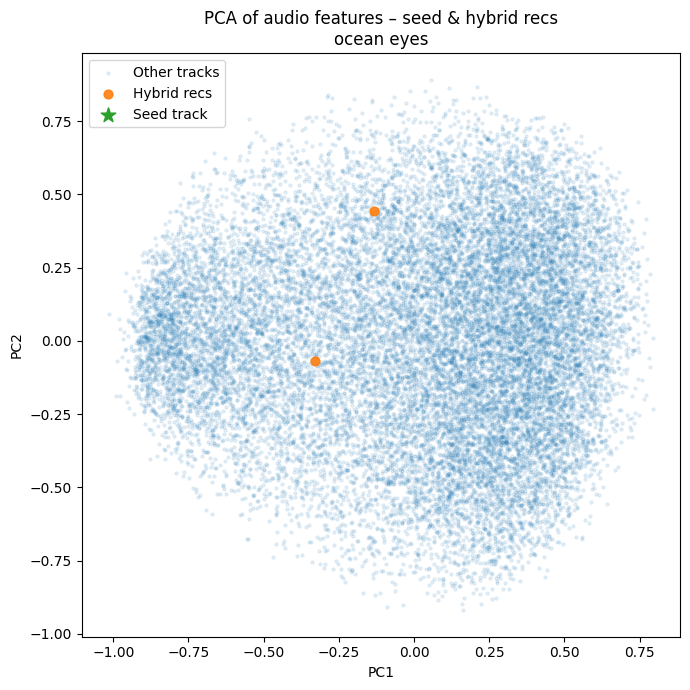

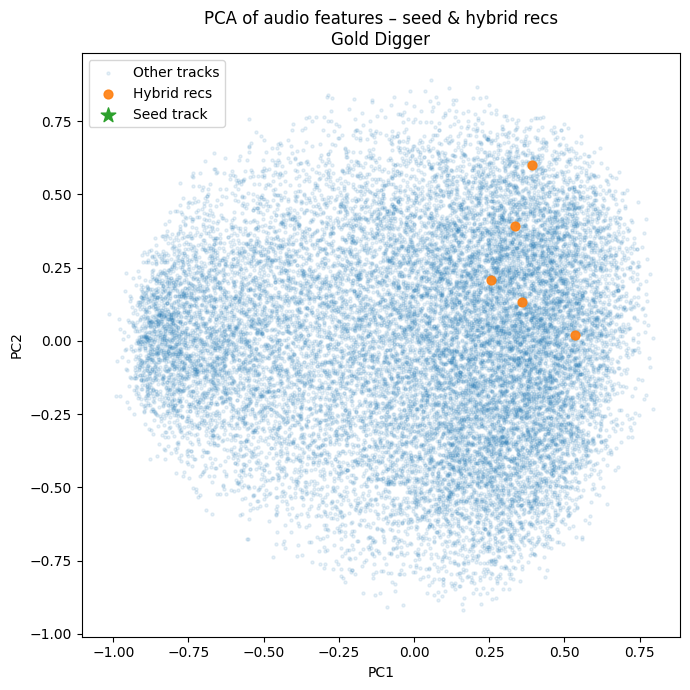

In [22]:
# Example visualisations
plot_seed_and_recs_on_pca(seed1, recs1, title_suffix=seed1["track_name"])
plot_seed_and_recs_on_pca(seed2, recs2, title_suffix=seed2["track_name"])
plot_seed_and_recs_on_pca(seed5, recs5, title_suffix=seed5["track_name"])


In [23]:
from collections import Counter

def hybrid_recs_for_playlist_tracks(track_ids, weights, top_k=20, candidate_pool=200):
    """
    Very rough: for each track in a playlist, get hybrid neighbours,
    accumulate scores across tracks, return top_k union (excluding seeds).
    """
    w_cos, w_als, w_i2v, w_cluster = weights
    score_counter = Counter()

    for tid in track_ids:
        df = hybrid_scores_for_track(
            tid,
            w_cos=w_cos,
            w_als=w_als,
            w_i2v=w_i2v,
            w_cluster=w_cluster,
            top_k=top_k,
            candidate_pool=candidate_pool,
        )
        for t2, s in zip(df["track_id"], df["hybrid_score"]):
            if t2 not in track_ids:  # don't recommend songs already in playlist
                score_counter[t2] += float(s)

    if not score_counter:
        return []

    ranked = [tid for tid, _ in score_counter.most_common(top_k)]
    return ranked


def evaluate_weights_on_playlists(weights, n_playlists=30, k=10, random_state=42):
    """
    Toy leave-one-out evaluation:
    - sample n_playlists
    - for each, hold out 1 random track as 'target'
    - build recommendations from remaining tracks
    - compute hit-rate@k and recall@k (here recall==hit because 1 target)
    """
    rng = np.random.default_rng(random_state)
    sampled_pids = rng.choice(inter_df_u["pid"].unique(), size=n_playlists, replace=False)

    hits = 0
    for pid in sampled_pids:
        tracks = inter_df_u.loc[inter_df_u["pid"] == pid, "track_id"].unique()
        if len(tracks) < 3:
            continue

        target_idx = rng.integers(len(tracks))
        target = tracks[target_idx]
        context = [t for t in tracks if t != target]

        recs = hybrid_recs_for_playlist_tracks(context, weights, top_k=k)

        if target in recs:
            hits += 1

    hit_rate = hits / n_playlists
    return hit_rate


# Example: search a coarse grid of weights
weight_grid = [
    (0.4, 0.4, 0.1, 0.1),
    (0.2, 0.5, 0.2, 0.1),
    (0.1, 0.4, 0.4, 0.1),
    (0.3, 0.3, 0.3, 0.1),
]

for w in weight_grid:
    hr = evaluate_weights_on_playlists(w, n_playlists=20, k=10)
    print(f"Weights (cos,ALS,i2v,cluster)={w} -> HitRate@10≈{hr:.3f}")


C:\Users\Kiera\AppData\Local\Temp\ipykernel_32512\4031460457.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(0.0)
C:\Users\Kiera\AppData\Local\Temp\ipykernel_32512\4031460457.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(0.0)
C:\Users\Kiera\AppData\Local\Temp\ipykernel_32512\4031460457.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior

Weights (cos,ALS,i2v,cluster)=(0.4, 0.4, 0.1, 0.1) -> HitRate@10≈0.000


C:\Users\Kiera\AppData\Local\Temp\ipykernel_32512\4031460457.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(0.0)
C:\Users\Kiera\AppData\Local\Temp\ipykernel_32512\4031460457.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(0.0)
C:\Users\Kiera\AppData\Local\Temp\ipykernel_32512\4031460457.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior

Weights (cos,ALS,i2v,cluster)=(0.2, 0.5, 0.2, 0.1) -> HitRate@10≈0.000


C:\Users\Kiera\AppData\Local\Temp\ipykernel_32512\4031460457.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(0.0)
C:\Users\Kiera\AppData\Local\Temp\ipykernel_32512\4031460457.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(0.0)
C:\Users\Kiera\AppData\Local\Temp\ipykernel_32512\4031460457.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior

Weights (cos,ALS,i2v,cluster)=(0.1, 0.4, 0.4, 0.1) -> HitRate@10≈0.050


C:\Users\Kiera\AppData\Local\Temp\ipykernel_32512\4031460457.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(0.0)
C:\Users\Kiera\AppData\Local\Temp\ipykernel_32512\4031460457.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(0.0)
C:\Users\Kiera\AppData\Local\Temp\ipykernel_32512\4031460457.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior

Weights (cos,ALS,i2v,cluster)=(0.3, 0.3, 0.3, 0.1) -> HitRate@10≈0.000


C:\Users\Kiera\AppData\Local\Temp\ipykernel_32512\4031460457.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(0.0)
C:\Users\Kiera\AppData\Local\Temp\ipykernel_32512\4031460457.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(0.0)
